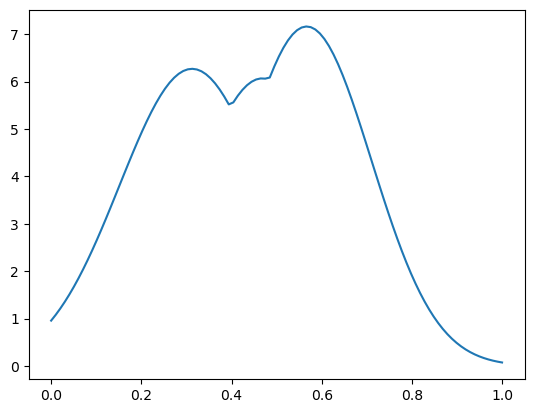

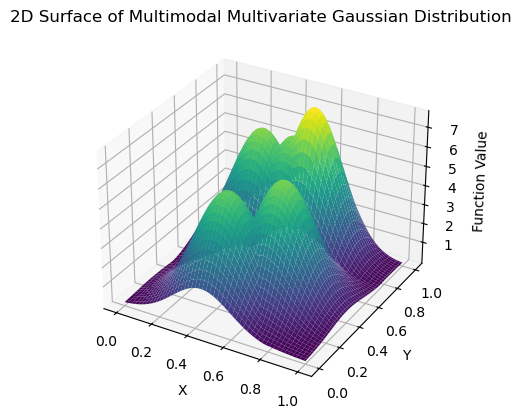

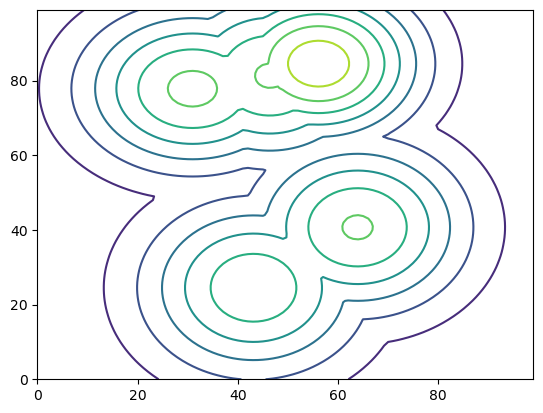

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

class MaxOfManyGaussians():
    def __init__(self, ndim, num_gaussians, bounds, std_bounds, seed = 500):
        self.ndim = ndim
        self.bounds = bounds
        self.std_bounds = np.array(std_bounds)
        self.num_gaussians = num_gaussians
        self.rg = np.random.default_rng(seed=seed)
        self.gaussians = self.generate_gaussians()

    def generate_gaussians(self):
        # Create a grid of points
        gaussians = []
        # Generate multiple 2D Gaussians
        for _ in range(self.num_gaussians):
            mean = []
            for b in self.bounds:
                mean.append(self.rg.uniform(*b, 1)[0])
            mean = np.array(mean)
            cov_bounds = self.std_bounds
            # cov = self.rg.uniform(*cov_bounds, (self.ndim, self.ndim))
            # cov = np.dot(cov, cov.T)  # Ensure the covariance matrix is positive semi-definite
            cov = np.diag(np.random.uniform(*cov_bounds, (self.ndim,self.ndim)))
            gaussians.append(multivariate_normal(mean, cov))
        return gaussians

    def evaluate(self, pos):
        Z = []
        for g in self.gaussians:
            Z.append(g.pdf(pos))
        Zmax = np.max(np.stack(Z), axis = 0)
        return Zmax

    def plot_2d_gaussians(self, grid_size=100, onlyContour=False):
        if self.ndim != 2:
            raise ValueError('Daniel Says: n_dim must equil 2')
        x = np.linspace(*self.bounds[0], grid_size)
        y = np.linspace(*self.bounds[1], grid_size)
        X, Y = np.meshgrid(x, y)
        pos = np.dstack((X, Y))
                
        
        Zmax = self.evaluate(pos)
        
        z = []
        yy = 0.8
        x_at_y = [(xi, yy) for xi in x]
        for g in self.gaussians:
            z.append(g.pdf(x_at_y))
        zmax = np.max(np.stack(z), axis = 0)
        #slice
        if not onlyContour:
            plt.figure()
            plt.plot(x, zmax)
            plt.show()
            
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot_surface(X, Y, Zmax, cmap='viridis')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Function Value')
            ax.set_title('2D Surface of Multimodal Multivariate Gaussian Distribution')
            ax.view_init(elev=30, azim=30-90)

        fig = plt.figure()
        plt.contour(Zmax)

mmg = MaxOfManyGaussians(2, 5, [(0,1), (0,1)], std_bounds=(0.02,0.03))

mmg.plot_2d_gaussians()

# max_value, max_pos = generate_2d_gaussians(num_gaussians, grid_size)
# print(f"Maximum Gaussian value: {max_value} at position {max_pos}")



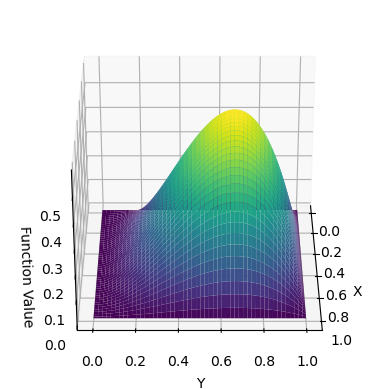

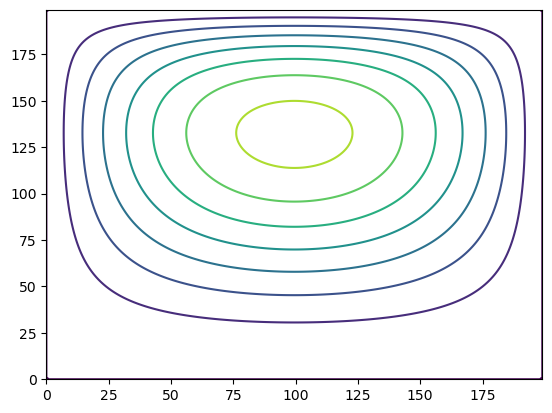

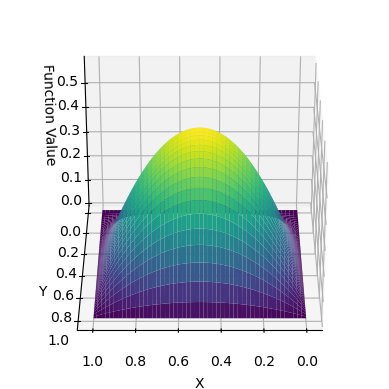

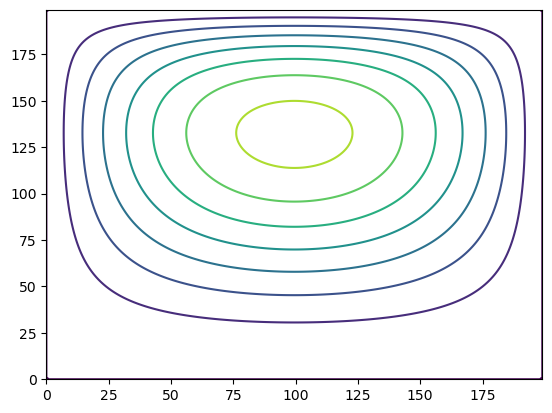

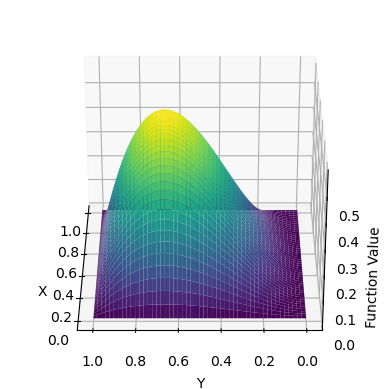

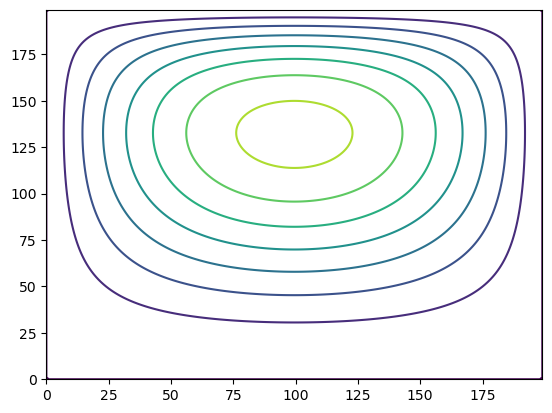

In [61]:
f = lambda x0, x1: 16.0 * (x0-1)*x0 * (x1-1)*x1*x1

# Generate a grid of coordinates
x = np.linspace(0, 1, 200)
y = np.linspace(0, 1, 200)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# Calculate the function value at each coordinate in the grid
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = f(X[i, j], Y[i, j])

def plot_surface(X,Y,Z, elev, azim):
    # Plot the 2D surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Function Value')
    ax.view_init(elev=elev, azim=azim)
    plt.show()
    fig = plt.figure()
    plt.contour(Z)


azim = [0,90,180]

for a in azim:
    plot_surface(X,Y,Z, elev=30, azim=a)


In [72]:
# import pysgpp library
import pysgpp

#create a two-dimensional piecewise bi-linear grid
dim = 2
grid = pysgpp.Grid.createLinearGrid(dim)

boundingBox = grid.getBoundingBox()
# boundingBox.setInterval(0, 0, 1.0)  # Set limits for the first dimension
# boundingBox.setInterval(1, 0, 1.0)  # Set limits for the second dimension
print('B',boundingBox.getBoundary(0).leftBoundary,boundingBox.getBoundary(0).rightBoundary)
print('B',boundingBox.getBoundary(1).leftBoundary, boundingBox.getBoundary(1).rightBoundary)

gridStorage = grid.getStorage()
# gridStorage.setBoundingBox(boundingBox)
print("dimensionality:                   {}".format(dim))

#create regular sparse grid, level 3
level = 3
gridGen = grid.getGenerator()
gridGen.regular(level)
print("number of initial grid points:    {}".format(gridStorage.getSize()))



#function to interpolate. This is a two-dimensional parabola. - nonsymmetric(!)
# f = lambda x0, x1: 16.0 * (x0-1)*x0 * (x1-1)*x1*x1
f = lambda x0, x1: mmg.evaluate([x0, x1])
#create coefficient vector with size corresponding to the grid size. Initially, all the values are set to zero.
alpha = pysgpp.DataVector(gridStorage.getSize())
print("length of alpha vector:           {}".format(alpha.getSize()))
# Obtain function values and refine adaptively 5 times
for refnum in range(10):
    # set function values in alpha
    for i in range(gridStorage.getSize()):
        gp = gridStorage.getPoint(i)
        alpha[i] = f(gp.getStandardCoordinate(0), gp.getStandardCoordinate(1))

    #Each time, we have to hierarchize the grid again, because in the previous interation, new grid points have been added.
    pysgpp.createOperationHierarchisation(grid).doHierarchisation(alpha)

    #Refine a single grid point each time. The SurplusRefinementFunctor chooses the grid point with the highest absolute surplus. Refining the point means, that all children of this point (if not already present) are added to the grid. Also all missing parents are added (recursively).
    gridGen.refine(pysgpp.SurplusRefinementFunctor(alpha, 1))
    print("refinement step {}, new grid size: {}".format(refnum+1, gridStorage.getSize()))

    #Extend alpha vector (new entries uninitialized). Note that right now, the surplus vector has the correct size again, but the values of the new points are set to zero. The correct surplus values will be inserted in the next iteration of the refinement loop.
    alpha.resizeZero(gridStorage.getSize())




B 0.0 1.0
B 0.0 1.0
dimensionality:                   2
number of initial grid points:    17
length of alpha vector:           17
refinement step 1, new grid size: 21
refinement step 2, new grid size: 24
refinement step 3, new grid size: 28
refinement step 4, new grid size: 32
refinement step 5, new grid size: 36
refinement step 6, new grid size: 40
refinement step 7, new grid size: 44
refinement step 8, new grid size: 48
refinement step 9, new grid size: 52
refinement step 10, new grid size: 56


56


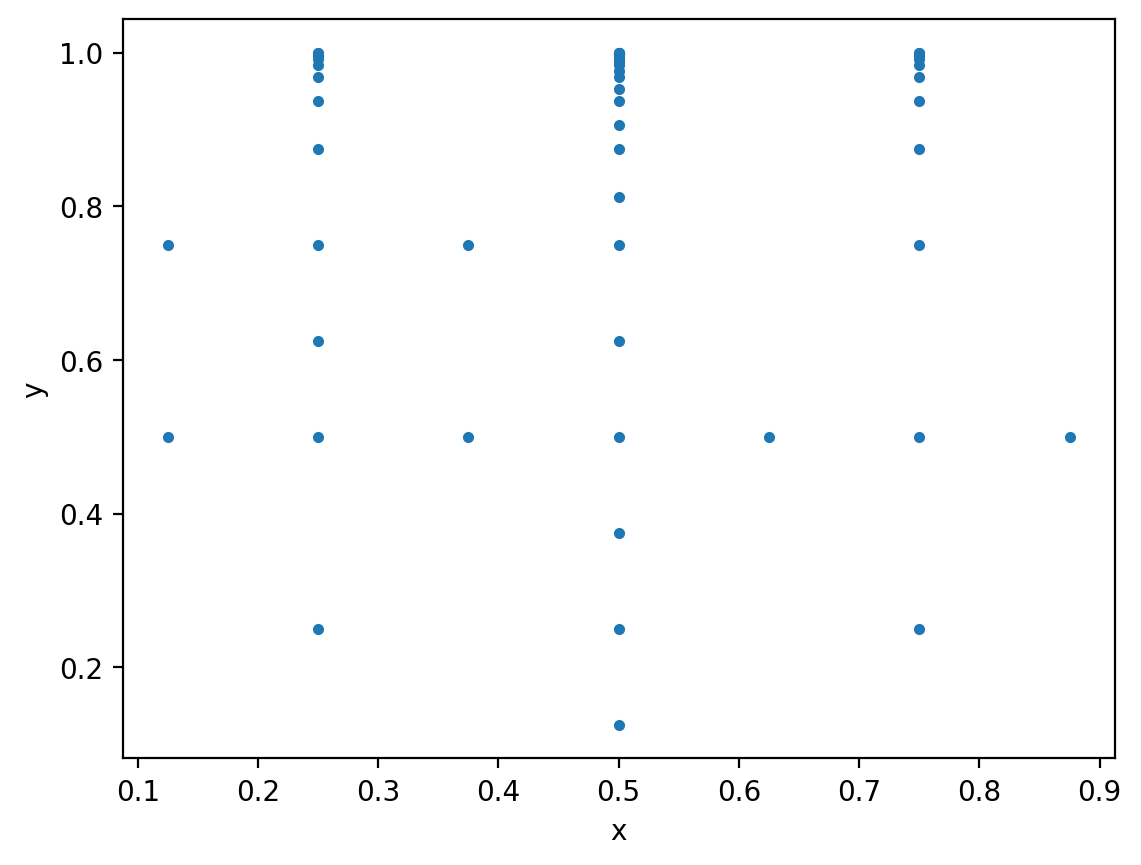

In [73]:
import matplotlib.pyplot as plt
x0 = []
x1 = []
y = alpha
x_train = []
for i in range(gridStorage.getSize()):
    gp = gridStorage.getPoint(i)
    x0.append(gp.getStandardCoordinate(0))
    x1.append(gp.getStandardCoordinate(1))
    x_train.append([gp.getStandardCoordinate(0),gp.getStandardCoordinate(1)])
    # opEval = createOperationEval(grid)
    # vec = DataVector(0)
    # vec.append(gp.getStandardCoordinate(0))
    # vec.append(gp.getStandardCoordinate(1))
    # print('vec', vec)
    # print('function value', f(gp.getStandardCoordinate(0), gp.getStandardCoordinate(1)))
    # print('opEval', opEval.eval(alpha,vec))
    
    # error[i] = pow(f(dataSet.get(i,0),dataSet.get(i,1))-opEval.eval(alpha,vec),2)
plt.figure(dpi=200)
plt.plot(x0,x1, '.')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim(0,1)
# plt.ylim(0,1)

print(len(x0))

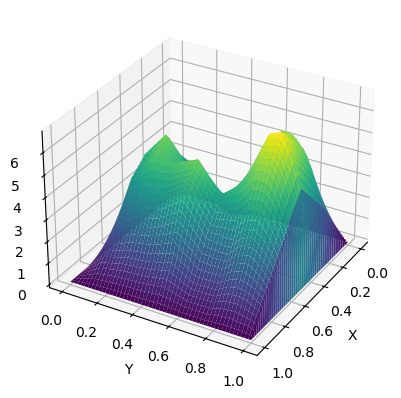

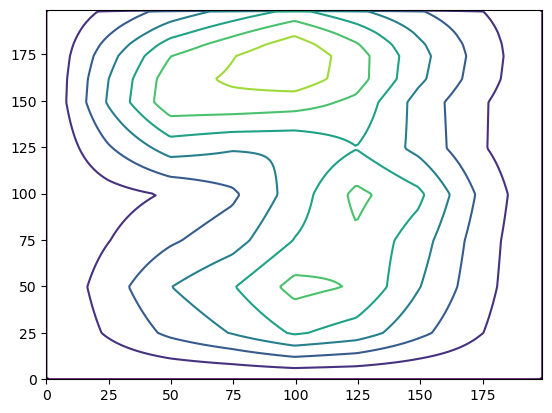

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pysgpp import DataVector, createOperationEval
# Define the function
def sgpp_OpEval(X, grid, alpha):
    vec = DataVector(0)
    vec.append(X[0])
    vec.append(X[1])
    opEval = createOperationEval(grid)
    z = opEval.eval(alpha,vec)
    return z 

sgpp_OpEval_f = lambda X: sgpp_OpEval(X, grid=grid, alpha=alpha)

# Generate 2D input data
x = np.linspace(0, 1, 200)
y = np.linspace(0, 1, 200)
X, Y = np.meshgrid(x, y)
Z = np.array([sgpp_OpEval_f(np.array([xi, yi])) for xi, yi in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)

# # Create a 3D mesh plot
# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, Z, cmap='viridis')

# # Set plot labels
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('sgpp_OpEval_f(X, Y)')
# ax.view_init(elev=30, azim=0)
# Show plot
# plt.show()

azim = [30]

for a in azim:
    plot_surface(X,Y,Z, elev=30, azim=a)


56


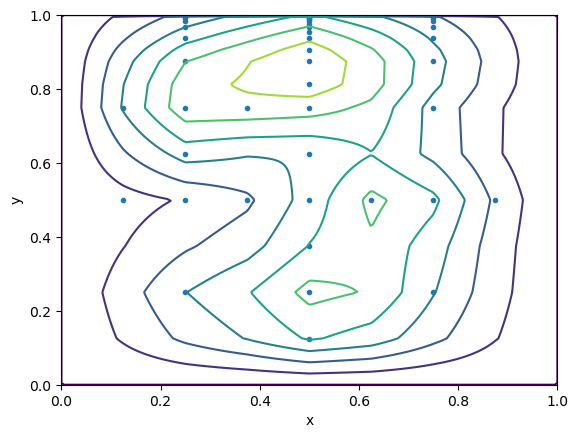

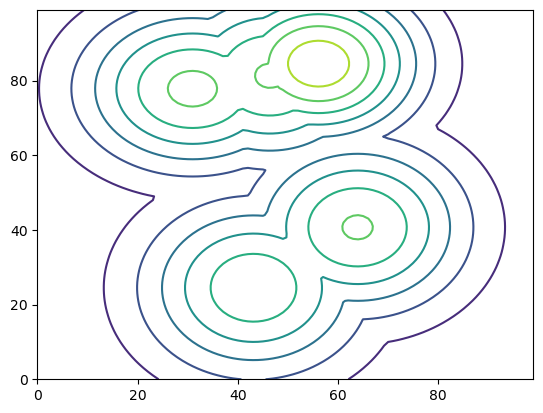

In [75]:
plt.figure(dpi=100)
plt.plot(x0,x1, '.')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.contour(X,Y,Z)
print(len(x0))

mmg.plot_2d_gaussians(onlyContour=True)